In [1]:
import autogluon.core as ag
from autogluon.tabular import TabularPrediction as task

import numpy as np

train_data = task.Dataset(file_path='https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')
subsample_size = 500  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
print(train_data.head())

label_column = 'occupation'
print("Summary of occupation column: \n", train_data['occupation'].describe())

new_data = task.Dataset(file_path='https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv')
test_data = new_data[5000:].copy()  # this should be separate data in your applications
y_test = test_data[label_column]
test_data_nolabel = test_data.drop(labels=[label_column], axis=1)  # delete label column
val_data = new_data[:5000]

metric = 'accuracy' # we specify eval-metric just for demo (unnecessary as it's the default)

Loaded data from: https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv | Columns = 15 / 15 | Rows = 39073 -> 39073


       age workclass  fnlwgt      education  education-num  \
6118    51   Private   39264   Some-college             10   
23204   58   Private   51662           10th              6   
29590   40   Private  326310   Some-college             10   
18116   37   Private  222450        HS-grad              9   
33964   62   Private  109190      Bachelors             13   

            marital-status        occupation    relationship    race      sex  \
6118    Married-civ-spouse   Exec-managerial            Wife   White   Female   
23204   Married-civ-spouse     Other-service            Wife   White   Female   
29590   Married-civ-spouse      Craft-repair         Husband   White     Male   
18116        Never-married             Sales   Not-in-family   White     Male   
33964   Married-civ-spouse   Exec-managerial         Husband   White     Male   

       capital-gain  capital-loss  hours-per-week  native-country   class  
6118              0             0              40   United-State

Loaded data from: https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv | Columns = 15 / 15 | Rows = 9769 -> 9769


No output_directory specified. Models will be saved in: AutogluonModels/ag-20201018_101947/
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to AutogluonModels/ag-20201018_101947/
AutoGluon Version:  0.0.15b20201017
Train Data Rows:    500
Train Data Columns: 14
Tuning Data Rows:    5000
Tuning Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	First 10 (of 15) unique label values:  [' Exec-managerial', ' Other-service', ' Craft-repair', ' Sales', ' Prof-specialty', ' Protective-serv', ' ?', ' Adm-clerical', ' Machine-op-inspct', ' Tech-support']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Fraction of data from classes with at least 10 examples that will be kept for training models: 0.978
Train Data Class Count: 12
Using Fea

Time out (secs) is 54.0


Please either provide filename or allow plot in get_training_curves
	0.1714	 = Validation accuracy score
	4.96s	 = Training runtime
	0.42s	 = Validation runtime
	0.2155	 = Validation accuracy score
	5.04s	 = Training runtime
	0.43s	 = Validation runtime
	0.1663	 = Validation accuracy score
	5.17s	 = Training runtime
	0.5s	 = Validation runtime
	0.1831	 = Validation accuracy score
	4.96s	 = Training runtime
	0.42s	 = Validation runtime
	0.1419	 = Validation accuracy score
	5.04s	 = Training runtime
	0.43s	 = Validation runtime
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
scheduler_options: Key 'tr

Time out (secs) is 54.0


	0.3008	 = Validation accuracy score
	2.08s	 = Training runtime
	0.05s	 = Validation runtime
	0.294	 = Validation accuracy score
	3.8s	 = Training runtime
	0.06s	 = Validation runtime
	0.3172	 = Validation accuracy score
	1.43s	 = Training runtime
	0.05s	 = Validation runtime
	0.2889	 = Validation accuracy score
	2.33s	 = Training runtime
	0.08s	 = Validation runtime
	0.3055	 = Validation accuracy score
	2.09s	 = Training runtime
	0.06s	 = Validation runtime
Fitting model: weighted_ensemble_k0_l1 ... Training model for up to 119.91s of the 73.97s of remaining time.
	0.3291	 = Validation accuracy score
	1.23s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 47.3s ...


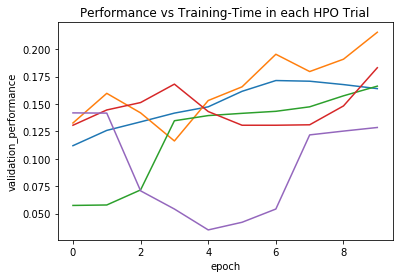

In [2]:
hp_tune = True  # whether or not to do hyperparameter optimization

nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'layers': ag.space.Categorical([100],[1000],[200,100],[300,200,100]),  # each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limits = 2*60  # train various models for ~2 min
num_trials = 5  # try at most 3 different hyperparameter configurations for each type of model
search_strategy = 'skopt'  # to tune hyperparameters using SKopt Bayesian optimization routine

predictor = task.fit(train_data=train_data, tuning_data=val_data, label=label_column,
                     time_limits=time_limits, eval_metric=metric, num_trials=num_trials,
                     hyperparameter_tune=hp_tune, hyperparameters=hyperparameters,
                     search_strategy=search_strategy)

In [3]:
y_pred = predictor.predict(test_data_nolabel)
print("Predictions:  ", list(y_pred)[:5])
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=False)

Evaluation: accuracy on test data: 0.3082407213252254


Predictions:   [' Exec-managerial', ' Craft-repair', ' Craft-repair', ' Adm-clerical', ' Sales']


*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       weighted_ensemble_k0_l1   0.329096       1.458375  21.640520                0.001525           1.233692            1       True         11
1    LightGBMClassifier/trial_7   0.317203       0.051970   1.430206                0.051970           1.430206            0       True          8
2    LightGBMClassifier/trial_9   0.305516       0.058836   2.094256                0.058836           2.094256            0       True         10
3    LightGBMClassifier/trial_5   0.300800       0.053770   2.083120                0.053770           2.083120            0       True          6
4    LightGBMClassifier/trial_6   0.294033       0.060181   3.800299                0.060181           3.800299            0       True          7
5    LightGBMClassifier/trial_8   0.288907       0.07777

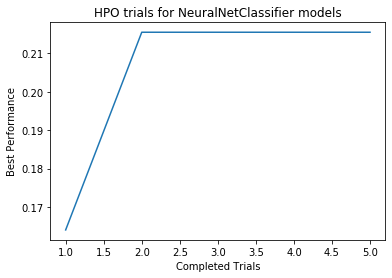

Plot summary of models saved to file: AutogluonModels/ag-20201018_101947/LightGBMClassifier_HPOmodelsummary.html
Plot summary of models saved to file: LightGBMClassifier_HPOmodelsummary.html
Plot of HPO performance saved to file: AutogluonModels/ag-20201018_101947/LightGBMClassifier_HPOperformanceVStrials.png


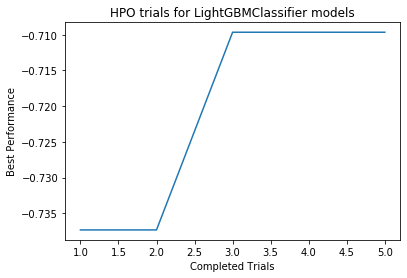

*** Details of Hyperparameter optimization ***
HPO for NeuralNetClassifier model:  Num. configurations tried = 5, Time spent = 29.567716598510742s, Search strategy = skopt
Best hyperparameter-configuration (validation-performance: accuracy = 0.21550133278654912):
{'activation▁choice': 2, 'dropout_prob': 0.1171319954718806, 'embedding_size_factor': 0.6285796516458554, 'layers▁choice': 1, 'learning_rate': 0.0031674867065318506, 'network_type▁choice': 0, 'use_batchnorm▁choice': 1, 'weight_decay': 5.723249636625901e-11}
HPO for LightGBMClassifier model:  Num. configurations tried = 5, Time spent = 12.81477689743042s, Search strategy = skopt
Best hyperparameter-configuration (validation-performance: accuracy = -0.7096575763789215):
{'feature_fraction': 0.861127967974357, 'learning_rate': 0.05881021095249142, 'min_data_in_leaf': 30, 'num_leaves': 52}
*** End of fit() summary ***


In [4]:
results = predictor.fit_summary()

In [ ]:
predictor = task.fit(train_data=train_data, label=label_column, eval_metric=metric,
                     num_bagging_folds=5, num_bagging_sets=1, stack_ensemble_levels=1,
                     hyperparameters = {'NN': {'num_epochs': 2}, 'GBM': {'num_boost_round': 20}}  # last  argument is just for quick demo here, omit it in real applications
                    )